# Progress Metering for OOH abstraction

This is a notebook designed to go through each output file in rwest-autotst-1 and determine the progress of each run.

In [107]:
import os, sys
rmg_path = os.getenv('RMGpy')
if rmg_path and rmg_path not in sys.path:
    sys.path.insert(1,rmg_path)
import os
import re
from collections import defaultdict, OrderedDict
import pandas as pd
from rmgpy.molecule import Molecule
from rmgpy.reaction import Reaction
import IPython
from IPython.display import display, Markdown
def mprint(s): display(Markdown(s))

In [124]:
directory = '/Users/nathan/Code/scratch_test/comparerTST/'
results = defaultdict(OrderedDict)
comparerFiles = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
k = 0
for fil in comparerFiles:
    if ".log" in fil:
        k += 1
results = defaultdict(OrderedDict)
not_ooh_abstraction = []
for i in range(1,k+1):
    r = results[i]
    filename = 'AutoTST-comparer.{0:d}.combined.log'.format(i)
    filepath = os.path.join(directory,filename)
    if os.path.exists(filepath):
        r['1 log file exists'] = 1
    else:
        continue
    with open(filepath) as f:
        lines = f.readlines()
    for j,l in enumerate(lines):
        m = re.match('comparerTST.py:141 performCalcs INFO chemkinRxn: (.*)', l)
        if m:
            rxn = m.group(1)
            if not ('SMILES="[O]O"'  in rxn and 'SMILES="OO"'  in rxn):
                not_ooh_abstraction.append(i)
                break
            r['0 reaction'] = eval(rxn)
            
        
        if 'We have generated a H_Abstraction reaction that matches, and used it to label the atoms' in l:
            r['2 matched H-abstraction'] = 1
          
        
        if 'Reading existing kinetics file' in l:
            r['XX using existing TS data file'] = 1
           
        
        if 'Generating a TS geometry via the direct guess method' in l:
            r['3 started making TS geometry'] = 1
            
            
        if 'Running loose optimization of TS with frozen center' in l:
            r['4A TS opt w frozen center'] = 1    
        if 'Optimization of TS reaction center distances' in l:
            r['4B TS opt of rxn center'] = 1  
        if 'Optimizing TS attempt' in l:
            r['4C TS optimization started'] = 1
        
        
        if 'verifyOutputFile INFO Verifying output file' in l:
            r['5A TS optimization complete'] = 1
            
            
        if 'Creating IRC file' in l:
            r['6A IRC file created'] = 1
        if "Verifying the IRC output file" in l:
            r['6B IRC calc complete'] = 1
        if "saveTSData INFO Saving TS result file" in l:
            r['6C IRC calc successful'] = 1
            
            
        if 'Symmetry input file written to' in l:
            r['7A starting Symmetry calculation'] = 1
        if 'Point group:' in l:
            r['7B Symmetry calc successful'] = 1
         
        
        if 'CanTherm execution initiated' in l:
            r['8 CanTherm started'] = 1
        if 'One or both of the barrier heights of' in l:
            r['8A CanTherm barrier height problem'] = -1
         
        
        if 'Yay, reaction kinetics calculated!!!' in l:
            r['ZZ overall success'] = 1

    
    if 'XX using existing TS data file' and 'ZZ overall success' in r.keys():
        r['YY successful prior calculation'] = 1
        
    if '5A TS optimization complete' and '6A IRC file created' in r.keys():
        r['5B TS successfully optimized'] = 1

for i in not_ooh_abstraction:
    del(results[i])
df = pd.DataFrame(results)
df

,5,7,8,12,13,14,16,17,21,22,...,456,457,458,459,460,461,462,463,464,465
0 reaction,"<Molecule ""OO""> + <Molecule ""[H]""> <=> <Molecu...","<Molecule ""[CH3]""> + <Molecule ""[O]O""> <=> <Mo...","<Molecule ""[CH3]""> + <Molecule ""[O]O""> <=> <Mo...","<Molecule ""[CH3]""> + <Molecule ""OO""> <=> <Mole...","<Molecule ""C""> + <Molecule ""[O]O""> <=> <Molecu...","<Molecule ""OO""> + <Molecule ""[O]""> <=> <Molecu...","<Molecule ""[O]O""> + <Molecule ""O""> <=> <Molecu...","<Molecule ""OO""> + <Molecule ""[OH]""> <=> <Molec...","<Molecule ""C#C""> + <Molecule ""[O]O""> <=> <Mole...","<Molecule ""[O]O""> + <Molecule ""C#C""> <=> <Mole...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1 log file exists,1,1,1,1,1,1,1,1,1,1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2 matched H-abstraction,1,1,1,1,1,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3 started making TS geometry,NaN,1,1,1,1,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4A TS opt w frozen center,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4B TS opt of rxn center,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4C TS optimization started,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5A TS optimization complete,NaN,1,1,1,1,1,NaN,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5B TS successfully optimized,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6A IRC file created,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
analysis = defaultdict(OrderedDict)

for i in range(df.shape[1]):
    i= i+1
    r = {}
    testRxn = str(df.loc['0 reaction'][i])
    success = df.loc['B overall success'][i]
    spec = testRxn.split('<=>')
    for d in spec:
        if """<Molecule "[O]O">""" in d:
            r1, r2 = d.split('+')
            if """<Molecule "[O]O">""" in r1:
                important = str(r2)
            else:
                important = str(r1)
    smiles = important.split("\"")[1]
    
    mol = Molecule(SMILES=smiles)
    r['Molar Mass'] = mol.getMolecularWeight()
    r['Radical Count'] = mol.getRadicalCount()
    r['Is Linear'] = mol.isLinear()
    r['Is Aromatic'] = mol.isAromatic()
    r['Is Rotor'] = mol.countInternalRotors()
    
    mol.getBonds
    if success == 1:
        r['Has Kinetics'] = True
    else:
        r['Has Kinetics'] = False
    analysis[smiles] = r



    

KeyError: 1

In [61]:
ana = pd.DataFrame(analysis).transpose()
ana.sort('Has Kinetics')

ana[ana['Has Kinetics']]

/Users/nathan/anaconda/envs/rmg_env/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,Has Kinetics,Is Aromatic,Is Linear,Is Rotor,Molar Mass,Radical Count
C,False,False,False,0,0.0160425,0
[CH2]C(=C)C=O,False,False,False,2,0.0690819,1
[CH2]C(=C)C[O],False,False,False,2,0.0700898,2
[CH2]C(C)(C)O,False,False,False,4,0.0731137,1
[CH2]C(C)(C)[O],False,False,False,3,0.0721057,2
[CH2]C(C)=O,False,False,False,2,0.0570712,1
[CH2]C(C)C,False,False,False,3,0.0571143,1
[CH2]C(C)[CH]O,False,False,False,4,0.0721057,2
[CH2]C(O)=CC,False,False,False,3,0.0710978,1
[CH2]C(O)CC,False,False,False,4,0.0731137,1


In [125]:
df.sum(axis=1)

0 reaction                             NaN
1 log file exists                     56.0
2 matched H-abstraction                NaN
3 started making TS geometry           NaN
4A TS opt w frozen center              NaN
4B TS opt of rxn center                NaN
4C TS optimization started             NaN
5A TS optimization complete            NaN
5B TS successfully optimized           NaN
6A IRC file created                    NaN
6B IRC calc complete                   NaN
6C IRC calc successful                 NaN
7A starting Symmetry calculation       NaN
7B Symmetry calc successful            NaN
8 CanTherm started                     NaN
8A CanTherm barrier height problem     NaN
XX using existing TS data file         NaN
YY successful prior calculation        NaN
ZZ overall success                     NaN
dtype: float64

In [126]:
df.count(axis=1)

0 reaction                            231
1 log file exists                     287
2 matched H-abstraction               231
3 started making TS geometry          164
4A TS opt w frozen center              95
4B TS opt of rxn center                94
4C TS optimization started             94
5A TS optimization complete           152
5B TS successfully optimized           77
6A IRC file created                    77
6B IRC calc complete                   93
6C IRC calc successful                 60
7A starting Symmetry calculation       69
7B Symmetry calc successful            69
8 CanTherm started                     68
8A CanTherm barrier height problem     18
XX using existing TS data file         67
YY successful prior calculation       116
ZZ overall success                    116
dtype: int64

# Finished IRC but failed it (33)

<Molecule "[CH3]"> + <Molecule "[O]O"> <=> <Molecule "OO"> + <Molecule "[CH2]">


<Molecule "[CH]=C"> + <Molecule "[O]O"> <=> <Molecule "OO"> + <Molecule "[CH]=[CH]">


<Molecule "C[CH2]"> + <Molecule "[O]O"> <=> <Molecule "OO"> + <Molecule "[CH]C">


<Molecule "C[CH2]"> + <Molecule "[O]O"> <=> <Molecule "OO"> + <Molecule "[CH]C">


<Molecule "[CH2]O"> + <Molecule "[O]O"> <=> <Molecule "OO"> + <Molecule "[CH]O">


<Molecule "C[O]"> + <Molecule "[O]O"> <=> <Molecule "OO"> + <Molecule "[CH2][O]">


<Molecule "[CH2]O"> + <Molecule "[O]O"> <=> <Molecule "OO"> + <Molecule "[CH]O">


<Molecule "[CH2]C=C"> + <Molecule "[O]O"> <=> <Molecule "OO"> + <Molecule "[CH]=C[CH2]">


<Molecule "[CH2]C=C"> + <Molecule "[O]O"> <=> <Molecule "OO"> + <Molecule "[CH]=C[CH2]">


<Molecule "[O]O"> + <Molecule "C=C=O"> <=> <Molecule "OO"> + <Molecule "[CH]=C=O">


<Molecule "[O]C=O"> + <Molecule "OO"> <=> <Molecule "O=CO"> + <Molecule "[O]O">


<Molecule "[O]O"> + <Molecule "C#CC=C"> <=> <Molecule "OO"> + <Molecule "C#C[C]=C">


<Molecule "C#CC=C"> + <Molecule "[O]O"> <=> <Molecule "OO"> + <Molecule "C#C[C]=C">


<Molecule "C=[C]C=C"> + <Molecule "[O]O"> <=> <Molecule "OO"> + <Molecule "[CH]=C[C]=C">


<Molecule "[CH]=CC=C"> + <Molecule "OO"> <=> <Molecule "C=CC=C"> + <Molecule "[O]O">


<Molecule "C=[C]C=C"> + <Molecule "OO"> <=> <Molecule "C=CC=C"> + <Molecule "[O]O">


<Molecule "[CH2]CC=C"> + <Molecule "[O]O"> <=> <Molecule "OO"> + <Molecule "[CH2]C[C]=C">


<Molecule "[CH2]CC=C"> + <Molecule "[O]O"> <=> <Molecule "OO"> + <Molecule "[CH2]C[C]=C">


<Molecule "C=CC=O"> + <Molecule "[O]O"> <=> <Molecule "OO"> + <Molecule "C=[C]C=O">


<Molecule "C=CCC"> + <Molecule "[O]O"> <=> <Molecule "OO"> + <Molecule "C=C[CH]C">


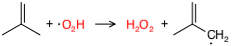

<Molecule "C=C(C)C"> + <Molecule "[O]O"> <=> <Molecule "OO"> + <Molecule "[CH2]C(=C)C">


<Molecule "CC=CC"> + <Molecule "[O]O"> <=> <Molecule "OO"> + <Molecule "[CH2]C=CC">


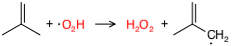

<Molecule "C=C(C)C"> + <Molecule "[O]O"> <=> <Molecule "OO"> + <Molecule "[CH2]C(=C)C">


<Molecule "CC=CC"> + <Molecule "[O]O"> <=> <Molecule "OO"> + <Molecule "[CH2]C=CC">


<Molecule "C=CCC"> + <Molecule "[O]O"> <=> <Molecule "OO"> + <Molecule "C=C[CH]C">


<Molecule "C=CCC"> + <Molecule "[O]O"> <=> <Molecule "OO"> + <Molecule "C=C[CH]C">


<Molecule "C=CCC"> + <Molecule "[O]O"> <=> <Molecule "OO"> + <Molecule "C=C[CH]C">


<Molecule "CC=CC"> + <Molecule "[O]O"> <=> <Molecule "OO"> + <Molecule "[CH2]C=CC">


<Molecule "CC=CC"> + <Molecule "[O]O"> <=> <Molecule "OO"> + <Molecule "[CH2]C=CC">


<Molecule "[CH2]CCC"> + <Molecule "[O]O"> <=> <Molecule "OO"> + <Molecule "[CH2]C[CH]C">


<Molecule "CCC=CO"> + <Molecule "[O]O"> <=> <Molecule "OO"> + <Molecule "C[CH]C=CO">


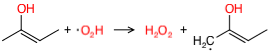

<Molecule "CC=C(C)O"> + <Molecule "[O]O"> <=> <Molecule "OO"> + <Molecule "[CH2]C(O)=CC">


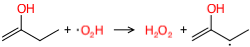

<Molecule "C=C(O)CC"> + <Molecule "[O]O"> <=> <Molecule "OO"> + <Molecule "C=C(O)[CH]C">


In [118]:
finished_but_failed_irc = df.T['6B IRC calc complete'] & (df.T['6C IRC calc successful']!=1)
df.T[finished_but_failed_irc]['0 reaction']
mprint("# Finished IRC but failed it ({})".format(sum(finished_but_failed_irc)))
for r in df.T[finished_but_failed_irc]['0 reaction']:
    display(r)
    print r

In [6]:
directory = "/Users/nathan/Code/scratch_test/bioTST/"
bioFiles = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
k = 0
for fil in bioFiles:
    if ".log" in fil:
        k += 1
results = defaultdict(OrderedDict)
for i in range(k):
    i = i + 1
    r = results[i]
    filename = 'AutoTST-biofuels.{0:d}.combined.log'.format(i)
    filepath = os.path.join(directory,filename)
    if os.path.exists(filepath):
        r['1 log file exists'] = 1
    else:
        continue
    with open(filepath) as f:
        lines = f.readlines()
    for j,l in enumerate(lines):
        m = re.match('autoTST-OOH.py:62 <module> INFO (.*)', l)
        if m:
            r['0 reaction'] = m.group(1)
        if 'We have generated a H_Abstraction reaction that matches, and used it to label the atoms' in l:
            r['2 matched H-abstraction'] = 1
        if 'Generating a TS geometry via the direct guess method' in l:
            r['3 started making TS geometry'] = 1
        if 'Reading existing ts file' in l:
            r['4 using existing TS data file'] = 1
        if 'Symmetry input file written to' in l:
            r['5 starting Symmetry calculation'] = 1
        if 'Point group:' in l:
            r['6 Symmetry calc successful'] = 1
        if 'line 295, in saveCoordinatesFromRDMol' in l:
            r['7 saveCoordinatesFromRDMol bug'] = -1
            print ''.join(lines[j-30:])
        if 'CanTherm execution initiated' in l:
            r['9 CanTherm started'] = 1
        if 'One or both of the barrier heights of' in l:
            r['9a CanTherm barrier height problem'] = -1
        if "Reading existing kinetics file" in l:
            r['A using prior calculation result'] = 1
        if 'Yay, reaction kinetics calculated!!!' in l:
            r['B overall success'] = 1


In [7]:
df = pd.DataFrame(results)
df

,1,2,3,4,5,6,7,8,9,10,...,774,775,776,777,778,779,780,781,782,783
1 log file exists,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2 matched H-abstraction,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3 started making TS geometry,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4 using existing TS data file,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5 starting Symmetry calculation,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6 Symmetry calc successful,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9 CanTherm started,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9a CanTherm barrier height problem,NaN,-1.0,-1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A using prior calculation result,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B overall success,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df.sum(axis=1)

1 log file exists                     691.0
2 matched H-abstraction               188.0
3 started making TS geometry          150.0
4 using existing TS data file          10.0
5 starting Symmetry calculation        36.0
6 Symmetry calc successful             36.0
9 CanTherm started                     36.0
9a CanTherm barrier height problem    -13.0
A using prior calculation result       38.0
B overall success                      58.0
dtype: float64

In [9]:
df.count(axis=1)

1 log file exists                     691
2 matched H-abstraction               188
3 started making TS geometry          150
4 using existing TS data file          10
5 starting Symmetry calculation        36
6 Symmetry calc successful             36
9 CanTherm started                     36
9a CanTherm barrier height problem     13
A using prior calculation result       38
B overall success                      58
dtype: int64